In [1]:
import tushare as ts
import seaborn as sns
import keras
import numpy as np
import pandas as pd
# import jtplot submodule from jupyterthemes
# from jupyterthemes import jtplot

# # currently installed theme will be used to
# # set plot style if no arguments provided
# jtplot.style()
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Using TensorFlow backend.


In [2]:
ts.set_token('53cd3b985c649c978160c6ec04bce24f4fbd2ebcb4673e8f2fba9a43')

pro = ts.pro_api()

sz1 = pro.daily(ts_code='000001.SZ', start_date='20170817', end_date='20190817')

C:\Users\GreenWood\Anaconda3\envs\tf_gpu_keras\lib\site-packages\tushare\util\upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [3]:
sz1 = sz1.drop(['ts_code'], axis=1)

In [4]:
sz1.head()

,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,20190816,15.09,15.14,14.78,14.90,14.94,-0.04,-0.2677,986902.93,1474900.257
1,20190815,14.64,14.96,14.60,14.94,14.97,-0.03,-0.2004,897376.26,1333117.725
2,20190814,15.14,15.22,14.80,14.97,14.89,0.08,0.5373,1360546.54,2038261.151
3,20190813,15.00,15.08,14.74,14.89,15.12,-0.23,-1.5212,1293736.44,1925835.288
4,20190812,14.61,15.12,14.60,15.12,14.52,0.60,4.1322,2733425.47,4084497.902


In [5]:
sz1['trade_date'] = pd.to_datetime(sz1['trade_date'])
sz1 = sz1.set_index('trade_date')

In [6]:
sz1 = sz1[::-1]
sz1.tail()

,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,
2019-08-12,14.61,15.12,14.60,15.12,14.52,0.60,4.1322,2733425.47,4084497.902
2019-08-13,15.00,15.08,14.74,14.89,15.12,-0.23,-1.5212,1293736.44,1925835.288
2019-08-14,15.14,15.22,14.80,14.97,14.89,0.08,0.5373,1360546.54,2038261.151
2019-08-15,14.64,14.96,14.60,14.94,14.97,-0.03,-0.2004,897376.26,1333117.725
2019-08-16,15.09,15.14,14.78,14.90,14.94,-0.04,-0.2677,986902.93,1474900.257


In [7]:
train_mean =  sz1[:'2018-08-17'].mean()
train_std = sz1[:'2018-08-17'].std()

In [8]:
sz1 -= train_mean
sz1 /= train_std

In [9]:
train_data = sz1[:'2018-08-17']

In [10]:
train_data.tail()

,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,
2018-08-13,-1.493230,-1.515349,-1.569139,-1.524104,-1.420351,-0.679116,-0.904620,-0.599880,-0.755465
2018-08-14,-1.550386,-1.588561,-1.543068,-1.555519,-1.533907,-0.172748,-0.244041,-1.200027,-1.127814
2018-08-15,-1.556736,-1.600763,-1.666906,-1.687461,-1.565450,-0.795970,-1.085680,-0.828729,-0.906468
2018-08-16,-1.740905,-1.680075,-1.738601,-1.693744,-1.697933,-0.016942,-0.036703,-0.878457,-0.943889
2018-08-17,-1.645646,-1.649570,-1.647352,-1.674895,-1.704241,0.138863,0.178574,-0.861138,-0.925665


In [11]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][3]
        yield samples, targets

In [12]:
len(sz1)

488

In [13]:
len(train_data)

246

In [14]:
sz1.shape

(488, 9)

In [15]:
lookback = 100
step = 1
delay = 1
batch_size = 8

train_size = len(train_data)
val_size = 120

sz1_values = sz1.values
train_gen = generator(sz1_values, 
                      lookback=lookback,
                      delay=delay, 
                      min_index=0,
                      max_index=train_size, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(sz1_values,
                    lookback=lookback,
                    delay=delay,
                    min_index=train_size,
                    max_index=train_size+val_size,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(sz1_values,
                     lookback=lookback,
                     delay=delay,
                     min_index=train_size+val_size,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (val_size - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(sz1_values) - val_size - train_size - 1 - lookback) // batch_size

In [24]:
next(test_gen)

(array([[[ 0.91366815,  1.00435482,  0.99886112, ...,  0.2717746 ,
           0.31201808,  0.41411356],
         [ 1.00892796,  0.91894114,  0.99886112, ...,  0.08943842,
           0.06057982,  0.17667215],
         [ 1.00892796,  0.86403234,  0.80984586, ..., -1.21144372,
           0.88957242,  0.87703617],
         ...,
         [ 1.55508425,  1.60225062,  1.65715564, ...,  1.10670227,
          -0.18354968,  0.09194483],
         [ 1.72020127,  1.59004866,  1.80706429, ...,  0.11694481,
          -0.88304313, -0.58116364],
         [ 1.76465585,  1.71206821,  1.87224197, ...,  0.21633646,
          -0.75896333, -0.45140105]],
 
        [[ 1.00892796,  0.91894114,  0.99886112, ...,  0.08943842,
           0.06057982,  0.17667215],
         [ 1.00892796,  0.86403234,  0.80984586, ..., -1.21144372,
           0.88957242,  0.87703617],
         [ 0.64694066,  0.64439715,  0.61431284, ..., -1.61520162,
           0.88355132,  0.81376405],
         ...,
         [ 1.72020127,  1.5900486

In [23]:
val_steps

2

In [17]:
test_steps

2

In [18]:
import matplotlib.pyplot as plt
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.initializers import Orthogonal

In [20]:
def get_model():
    model = Sequential()
    model.add(
        layers.Bidirectional(layers.LSTM(32, 
                                 dropout=0.2, 
                                 recurrent_dropout=0.5, 
                                 kernel_initializer=Orthogonal(seed=7)),
                            input_shape=(None, sz1_values.shape[-1])
                            )
    )
    model.add(layers.Dense(16))
    model.add(layers.Dense(1))
    return model

In [21]:
model = get_model()
model.compile(optimizer=RMSprop(), loss='mse')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                10752     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 11,809
Trainable params: 11,809
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=30 ,
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
30/30 [==============================] - 13s 432ms/step - loss: 0.2337 - val_loss: 0.1292
Epoch 2/20
30/30 [==============================] - 10s 325ms/step - loss: 0.1164 - val_loss: 0.0655
Epoch 3/20
30/30 [==============================] - 10s 340ms/step - loss: 0.0911 - val_loss: 0.1093
Epoch 4/20
30/30 [==============================] - 10s 329ms/step - loss: 0.1016 - val_loss: 0.0845
Epoch 5/20
30/30 [==============================] - 10s 329ms/step - loss: 0.0883 - val_loss: 0.0680
Epoch 6/20
30/30 [==============================] - 10s 336ms/step - loss: 0.0887 - val_loss: 0.1350
Epoch 7/20
30/30 [==============================] - 10s 335ms/step - loss: 0.0902 - val_loss: 0.0871
Epoch 8/20
30/30 [==============================] - 10s 335ms/step - loss: 0.0849 - val_loss: 0.1834
Epoch 9/20
30/30 [==============================] - 10s 335ms/step - loss: 0.0836 - val_loss: 0.1478
Epoch 10/20
30/30 [========================

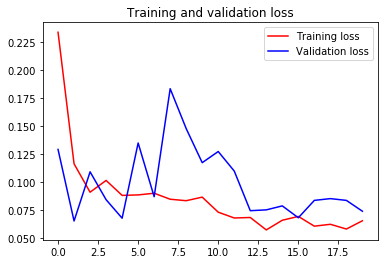

In [23]:
plot_loss(history)

In [24]:
model.evaluate_generator(test_gen, steps=test_steps)

0.4380497336387634

In [25]:
val_set = sz1_values[train_size: train_size+val_size]
real_val = val_set[lookback: , 3]
pred_val = []
for i in range(val_size - lookback):
    window = val_set[i: i + lookback]
    window = window.reshape(1, len(window), -1)
    pred_val.append(model.predict(window)[0, 0])
pred_val = np.array(pred_val)

In [26]:
len(pred_val)

20

c:\users\greenwood\anaconda3\envs\tf_gpu_keras\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


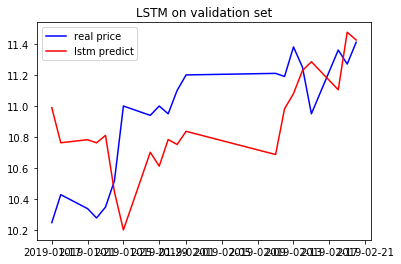

In [27]:
date = sz1.iloc[train_size + lookback: train_size + val_size].index
real_val = real_val * train_std['close'] + train_mean['close']
pred_val = pred_val * train_std['close'] + train_mean['close']
plt.figure()

plt.plot(date, real_val, 'b', label='real price')
plt.plot(date, pred_val, 'r', label='lstm predict')
plt.title('LSTM on validation set')
plt.legend()

plt.show()